In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from nanonets import NanoparticleElectrostatic
from nanonets.utils import display_network

plt.style.use(["science","bright","grid"])

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def force_directed_packing(initial_positions: dict, radii_pos_keys: np.ndarray, radius_neg_keys: float = 10.0,
                           min_surface_dist: float = 1.0,max_iter: int = 1000, resolution_steps: int = 5,
                           k_repel: float = 1.0,k_attract: float = 0.01,step_size: float = 0.05,
                           convergence_threshold: float = 1e-3, planarity_safety_factor: float = 0.4) -> dict:
    """
    Arranges spheres using a force-directed layout with a guaranteed
    non-overlapping final state.

    This function adds a "hard push" collision resolution step after each
    force-based update to ensure the minimum distance constraint is always met.

    Attributes
    ----------
        initial_positions : dict
            Dict mapping sphere index {idx: np.array([x, y]), ...}. Can contain positive and negative integer keys.
        radii_pos_keys : np.ndarray
            NumPy array where radii_pos_keys[i] is the radius for sphere with positive key `i`.
        radius_neg_keys : float
            The single, constant radius for all spheres with negative keys.
        min_surface_dist : float
            The minimum required distance between surfaces.
        max_iter : int
            The maximum number of simulation steps.
        resolution_steps : int
            How many times to run the collision resolution step per main iteration. Important for stability.
        k_repel : float
            Spring constant for the repulsive force.
        k_attract : float
            Spring constant for the attractive force.
        step_size : float
            The base speed of the simulation. Determines the intended movement distance
            before planarity capping is applied. Recommended: 0.01-0.1.
        convergence_threshold : float
            The desired *average* movement per sphere to consider the system converged.
            The simulation stops if `total_movement < num_spheres * threshold`.
            Recommended: 1e-6 to 1e-8 for high precision.
        planarity_safety_factor : float
            Limits a sphere's movement to this fraction of the distance to its
            nearest neighbor. The key parameter for preserving planarity.
            Recommended: 0.3-0.5.
    
    Returns
    -------
        dict
            A dictionary with the final, updated positions for all spheres.
    """

    if not initial_positions:
        return {}
        
    positions = {idx: np.copy(pos) for idx, pos in initial_positions.items()}
    num_spheres = len(positions)
    sphere_indices = list(positions.keys())

    # The center of mass is the single point of attraction
    initial_center_of_mass = np.mean(np.array(list(positions.values())), axis=0)

    for i in range(max_iter):
        net_forces = {idx: np.zeros(2) for idx in sphere_indices}
        
        # --- 1. Calculate Repulsive and Attractive Forces ---
        for j in range(num_spheres):
            # Attractive Force
            idx_j = sphere_indices[j]
            vec_to_center = initial_center_of_mass - positions[idx_j]
            net_forces[idx_j] += k_attract * vec_to_center
            
            # Repulsive Forces
            for k in range(j + 1, num_spheres):
                idx1, idx2 = sphere_indices[j], sphere_indices[k]
                pos1, pos2 = positions[idx1], positions[idx2]
                radius1 = radii_pos_keys[idx1] if idx1 >= 0 else radius_neg_keys
                radius2 = radii_pos_keys[idx2] if idx2 >= 0 else radius_neg_keys
                
                vec = pos2 - pos1
                dist = np.linalg.norm(vec)
                target_dist = radius1 + radius2 + min_surface_dist
                
                if dist < target_dist and dist > 1e-9:
                    overlap = target_dist - dist
                    force_magnitude = k_repel * overlap
                    direction = vec / dist
                    force_vec = force_magnitude * direction
                    net_forces[idx1] -= force_vec
                    net_forces[idx2] += force_vec

        # --- 2. Dynamically Capped Position Update (for Planarity) ---
        total_relative_movement = 0.0
        
        # Recalculate distance matrix in each iteration as positions change
        pos_array = np.array([positions[i] for i in sphere_indices])
        dist_matrix = np.linalg.norm(pos_array[:, np.newaxis, :] - pos_array[np.newaxis, :, :], axis=2)
        
        for j, idx in enumerate(sphere_indices):
            force = net_forces[idx]
            
            # **FIXED LOGIC**: Use step_size to determine intended movement
            intended_movement_vector = step_size * force
            
            # Find distance to the nearest other sphere to use for the cap
            min_dist_to_neighbor = np.min(dist_matrix[j] + np.eye(num_spheres)[j] * 1e9)
            max_allowed_movement = planarity_safety_factor * min_dist_to_neighbor
            
            intended_dist = np.linalg.norm(intended_movement_vector)
            
            # If intended movement is too large, cap it to the allowed maximum
            if intended_dist > max_allowed_movement:
                movement_vector = intended_movement_vector * (max_allowed_movement / intended_dist)
            else:
                movement_vector = intended_movement_vector

            positions[idx] += movement_vector
            radius = radii_pos_keys[idx] if idx >0 else radius_neg_keys
            total_relative_movement += np.linalg.norm(movement_vector) / (radius + 1e-9)
            
        # --- 3. Hard Constraint Projection (for Non-Overlap Guarantee) ---
        for _ in range(resolution_steps):
            for j in range(num_spheres):
                for k in range(j + 1, num_spheres):
                    idx1, idx2 = sphere_indices[j], sphere_indices[k]
                    # ... [This code block is correct and remains unchanged] ...
                    pos1, pos2 = positions[idx1], positions[idx2]
                    radius1 = radii_pos_keys[idx1] if idx1 >= 0 else radius_neg_keys
                    radius2 = radii_pos_keys[idx2] if idx2 >= 0 else radius_neg_keys
                    vec = pos2 - pos1
                    dist = np.linalg.norm(vec)
                    target_dist = radius1 + radius2 + min_surface_dist
                    if dist < target_dist and dist > 1e-9:
                        overlap = target_dist - dist
                        direction = vec / dist
                        positions[idx1] -= direction * (overlap / 2)
                        positions[idx2] += direction * (overlap / 2)

        avg_relative_movement = total_relative_movement / num_spheres
        # --- 4. Check for Convergence ---
        # Using the robust relative threshold
        if i > 10 and avg_relative_movement < convergence_threshold:
            print(f"Converged after {i+1} iterations.")
            break
    else:
        print(f"Reached max iterations ({max_iter}).")
        
    return positions


# Lattice Networks w/o disorder

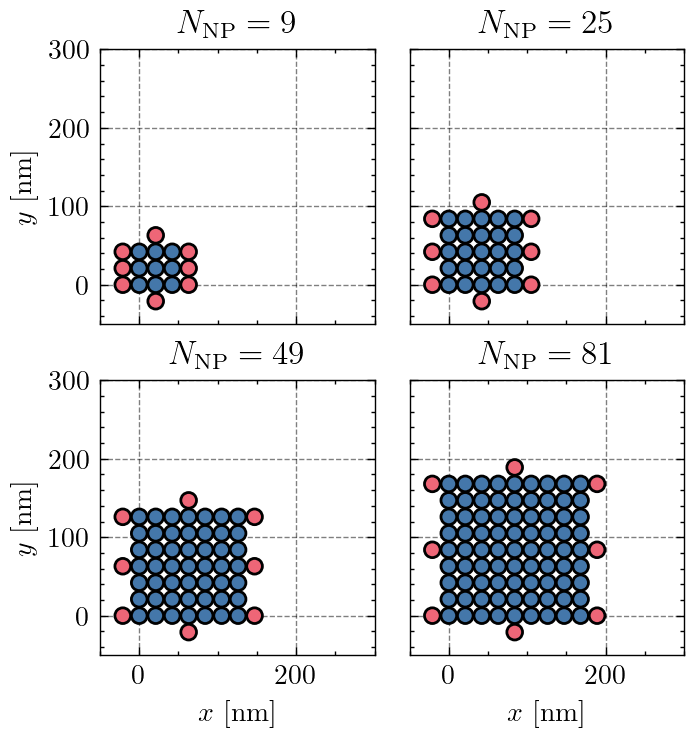

In [3]:
fig = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*1.8)
fig.set_figheight(fig.get_figheight()*1.4)
for i, N in enumerate([3,5,7,9]):
    ax              = fig.add_subplot(2,2,i+1)
    N_x, N_y        = N,N
    electrode_pos   = [[0,0],[N_x//2,0],[N_x-1,0],[0,(N_y-1)//2],[N_x-1,(N_y-1)//2],[0,N_y-1],[N_x//2,N_y-1],[N_x-1,N_y-1]]
    lattice_net     = NanoparticleElectrostatic()

    # Build Network and attach Electrodes
    lattice_net.lattice_network(N_x, N_y)
    lattice_net.add_electrodes_to_lattice_net(electrode_pos)
    lattice_net.init_nanoparticle_radius()
    lattice_net.pack_for_cubic()

    G_lat   = lattice_net.get_graph()
    pos_lat = lattice_net.get_positions()
    rad_lat = lattice_net.get_radius()

    fig,ax  = display_network(G_lat, pos_lat, rad_lat, fig=fig, ax=ax)
    _       = ax.set_xlim(-50,300)
    _       = ax.set_ylim(-50,300)
    _       = ax.set_title("$N_\\textrm{NP} = "+f"{N*N}$")
    if i >= 2:
        _ = ax.set_xlabel("$x$ [nm]")
    else:
        _ = ax.set_xticklabels("")
    if i % 2 == 0:
        _ = ax.set_ylabel("$y$ [nm]")
    else:
        _ = ax.set_yticklabels("")
    
fig.savefig("lattice_vs_system_size.pdf")

# Disorder Networks w/o disorder

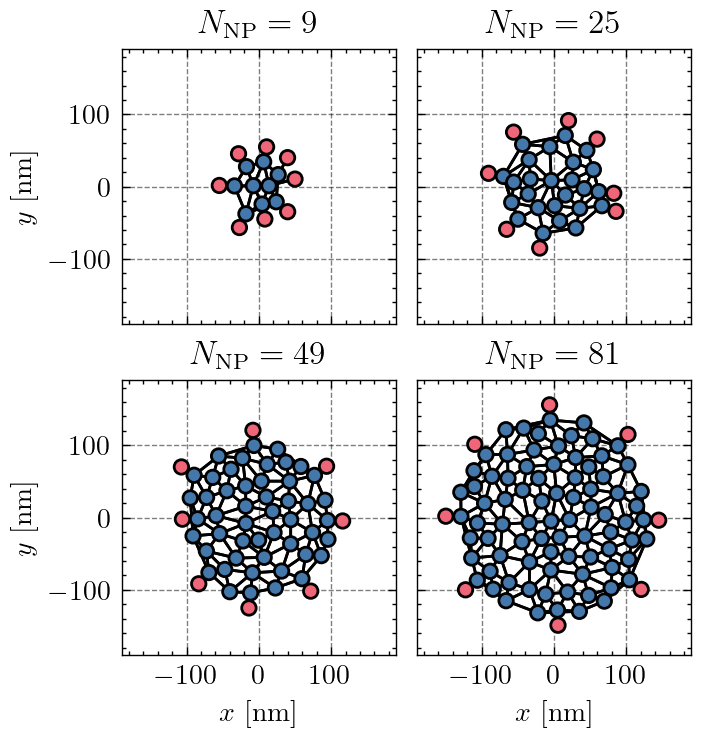

In [10]:
fig = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*1.8)
# fig.set_figheight(fig.get_figheight()*1.5)
fig.set_figheight(fig.get_figheight()*1.4)
for i, N_particles in enumerate([9,25,49,81]):
    ax              = fig.add_subplot(2,2,i+1)
    electrode_pos   = [[-1,-1],[0,-1],[1,-1],[-1,0],[1,0],[-1,1],[0,1],[1,1]]
    random_net      = NanoparticleElectrostatic()

    # Build Network and attach Electrodes
    random_net.random_network(N_particles)
    random_net.add_electrodes_to_random_net(electrode_pos)
    random_net.init_nanoparticle_radius()
    random_net.pack_planar_circles(max_iter=1000)

    G_rng           = random_net.get_graph()
    pos_rng         = random_net.get_positions()
    rad_rng         = random_net.get_radius()
    # pos_rng         = force_directed_packing(pos_rng, rad_rng, k_attract=0.1, convergence_threshold=1e-3, step_size=0.02, max_iter=500)

    fig,ax  = display_network(G_rng, pos_rng, rad_rng, fig=fig, ax=ax)
    _       = ax.set_xlim(-190,190)
    _       = ax.set_ylim(-190,190)
    _       = ax.set_title("$N_\\textrm{NP} = "+f"{N_particles}$")
    if i >= 2:
        _ = ax.set_xlabel("$x$ [nm]")
    else:
        _ = ax.set_xticklabels("")
    if i % 2 == 0:
        _ = ax.set_ylabel("$y$ [nm]")
    else:
        _ = ax.set_yticklabels("")
    
fig.savefig("disorder_vs_system_size.pdf")

Reached max iterations (10).


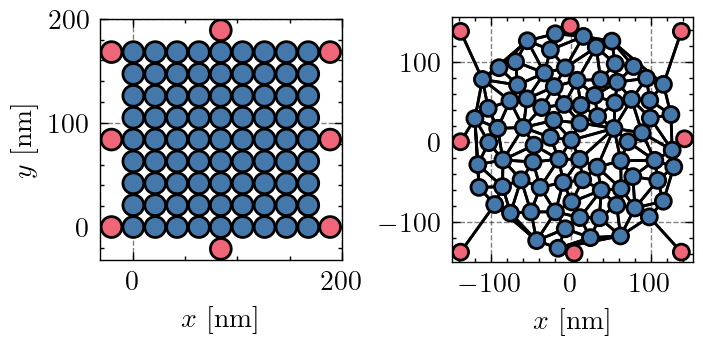

In [27]:
G_lat           = lattice_net.get_graph()
pos_lat         = lattice_net.get_positions()
rad_lat         = lattice_net.get_radius()
net_topo_lat    = lattice_net.get_net_topology()

G_rng           = random_net.get_graph()
pos_rng         = random_net.get_positions()
rad_rng         = random_net.get_radius()
net_topo_rng    = random_net.get_net_topology()
pos_rng         = force_directed_packing(pos_rng, rad_rng, k_attract=0.1, convergence_threshold=1e-3, step_size=0.02, max_iter=10)

fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot(1,2,1)
fig,ax  = display_network(G_lat, pos_lat, rad_lat, fig=fig, ax=ax)
_       = ax.set_xlabel("$x$ [nm]")
_       = ax.set_ylabel("$y$ [nm]")
ax      = fig.add_subplot(1,2,2)
fig,ax  = display_network(G_rng, pos_rng, rad_rng, fig=fig, ax=ax)
_       = ax.set_xlabel("$x$ [nm]")

In [4]:
voltage_values = np.random.normal(size=len(electrode_pos)+1)

lattice_net.calc_capacitance_matrix()
lattice_net.calc_electrode_capacitance_matrix()
lattice_net.init_charge_vector(voltage_values)

c_mat   = lattice_net.get_capacitance_matrix()
c_e_mat = lattice_net.get_electrode_capacitance_matrix()
q_vec   = lattice_net.get_charge_vector()

print("Capacitance Matrix:\n", np.round(c_mat,2))
print("Electrode Capacitance Matrix:\n", np.round(c_e_mat,2))
print("Voltage Vector:\n", np.round(voltage_values,2))
print("Initial Charge Vector:\n", np.round(q_vec,2))

Capacitance Matrix:
 [[33.67 -2.56 -0.74 ... -0.13 -0.12 -0.11]
 [-2.56 36.7  -2.56 ... -0.14 -0.13 -0.12]
 [-0.74 -2.56 38.55 ... -0.15 -0.14 -0.13]
 ...
 [-0.13 -0.14 -0.15 ... 36.71 -2.56 -0.74]
 [-0.12 -0.13 -0.14 ... -2.56 34.15 -2.56]
 [-0.11 -0.12 -0.13 ... -0.74 -2.56 29.58]]
Electrode Capacitance Matrix:
 [[0.16 0.16 0.15 0.15 0.14 0.13 0.13 0.12 0.11 0.18 0.18 0.17 0.16 0.15
  0.14 0.14 0.13 0.12 0.21 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.24
  0.23 0.22 0.2  0.19 0.17 0.16 0.14 0.13 0.29 0.28 0.26 0.23 0.21 0.19
  0.17 0.15 0.14 0.37 0.34 0.3  0.26 0.23 0.2  0.18 0.16 0.15 0.51 0.44
  0.37 0.3  0.26 0.22 0.19 0.17 0.15 0.81 0.6  0.44 0.34 0.28 0.23 0.2
  0.17 0.16 2.56 0.8  0.51 0.37 0.29 0.24 0.21 0.18 0.16 0.14]
 [2.56 0.81 0.51 0.37 0.29 0.24 0.21 0.18 0.16 0.81 0.6  0.44 0.34 0.28
  0.23 0.2  0.18 0.16 0.51 0.44 0.37 0.3  0.26 0.22 0.19 0.17 0.15 0.37
  0.34 0.3  0.26 0.23 0.2  0.18 0.16 0.15 0.29 0.28 0.26 0.23 0.21 0.19
  0.17 0.15 0.14 0.24 0.23 0.22 0.2  0.19 0.17

# Networks with disorder

In [13]:
# Radius Disorder
r_mean, r_std       = 10.0, 2.0

# Lattice
N_x, N_y            = 9,9
electrode_pos       = [[0,0],[N_x//2,0],[N_x-1,0],[0,(N_y-1)//2],[N_x-1,(N_y-1)//2],[0,N_y-1],[N_x//2,N_y-1],[N_x-1,N_y-1]]
lattice_net         = NanoparticleElectrostatic()

# Build Network and attach Electrodes
lattice_net.lattice_network(N_x, N_y)
lattice_net.add_electrodes_to_lattice_net(electrode_pos)
# lattice_net.add_np_to_output()
lattice_net.init_nanoparticle_radius(mean_radius=r_mean, std_radius=r_std)
lattice_net.pack_planar_circles()

# Lattice
N_particles     = 81
electrode_pos   = [[-1,-1],[0,-1],[1,-1],[-1,0],[1,0],[-1,1],[0,1],[1,1]]
random_net      = NanoparticleElectrostatic()

# Build Network and attach Electrodes
random_net.random_network(N_particles)
random_net.add_electrodes_to_random_net(electrode_pos)
# random_net.add_np_to_output()
random_net.init_nanoparticle_radius(mean_radius=r_mean, std_radius=r_std)
random_net.pack_planar_circles()

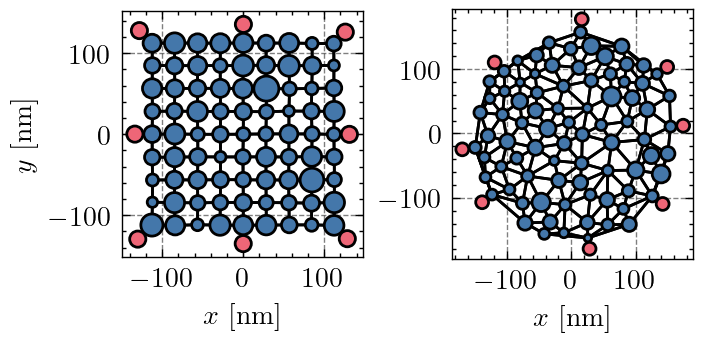

In [15]:
G_lat           = lattice_net.get_graph()
pos_lat         = lattice_net.get_positions()
rad_lat         = lattice_net.get_radius()
net_topo_lat    = lattice_net.get_net_topology()

G_rng           = random_net.get_graph()
pos_rng         = random_net.get_positions()
rad_rng         = random_net.get_radius()
net_topo_rng    = random_net.get_net_topology()

fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot(1,2,1)
fig,ax  = display_network(G_lat, pos_lat, rad_lat, fig=fig, ax=ax)
_       = ax.set_xlabel("$x$ [nm]")
_       = ax.set_ylabel("$y$ [nm]")
ax      = fig.add_subplot(1,2,2)
fig,ax  = display_network(G_rng, pos_rng, rad_rng, fig=fig, ax=ax)
_       = ax.set_xlabel("$x$ [nm]")

In [7]:
voltage_values = np.random.normal(size=len(electrode_pos)+1)

random_net.calc_capacitance_matrix()
random_net.calc_electrode_capacitance_matrix()
random_net.init_charge_vector(voltage_values)

c_mat   = random_net.get_capacitance_matrix()
c_e_mat = random_net.get_electrode_capacitance_matrix()
q_vec   = random_net.get_charge_vector()

print("Capacitance Matrix:\n", np.round(c_mat,2))
print("Electrode Capacitance Matrix:\n", np.round(c_e_mat,2))
print("Voltage Vector:\n", np.round(voltage_values,2))
print("Initial Charge Vector:\n", np.round(q_vec,2))

Capacitance Matrix:
 [[28.16 -0.42 -0.33 ... -0.28 -0.24 -0.14]
 [-0.42 18.75 -0.18 ... -0.16 -0.15 -0.09]
 [-0.33 -0.18 43.24 ... -2.57 -0.24 -0.15]
 ...
 [-0.28 -0.16 -2.57 ... 45.24 -0.23 -0.15]
 [-0.24 -0.15 -0.24 ... -0.23 34.19 -0.71]
 [-0.14 -0.09 -0.15 ... -0.15 -0.71 24.47]]
Electrode Capacitance Matrix:
 [[0.23 0.16 0.31 0.16 0.07 0.31 0.1  0.15 2.85 0.11 0.12 0.12 0.09 0.13
  0.1  0.33 0.12 0.32 0.18 0.1  0.17 0.3  0.21 0.2  0.32 0.13 0.18 0.69
  0.09 0.24 0.15 0.09 0.52 0.11 0.13 0.09 0.34 0.07 0.15 0.11 0.13 0.11
  0.08 0.14 0.16 0.09 0.1  0.14 0.17 0.19 0.25 0.11 0.32 0.19 0.19 0.17
  0.11 0.16 0.1  0.14 0.09 0.62 0.13 0.1  0.13 0.51 0.09 0.17 0.1  0.18
  0.16 0.12 0.18 0.28 0.64 0.11 0.22 0.1  0.12 0.3  0.13 0.09]
 [0.18 0.14 0.16 0.22 0.17 0.15 0.1  0.08 0.14 0.11 0.07 0.1  0.2  0.14
  0.16 0.11 0.8  0.13 0.13 0.43 0.36 0.17 0.25 0.17 0.18 0.36 0.28 0.18
  0.2  0.19 0.29 0.1  0.13 0.06 0.17 0.16 0.21 0.09 0.29 0.22 0.78 0.16
  0.09 0.27 0.11 0.06 0.08 0.17 0.11 0.23 0.1

# Networks with two NP Types

In [13]:
# Lattice
N_x, N_y            = 9,9
electrode_pos       = [[0,N_y-1],[0,0],[N_x-1,0],[N_x//2,0],[N_x-1,N_y-1]]
lattice_net         = NanoparticleElectrostatic()

# Two NP Types
r_mean_1, r_std_1   = 10.0, 1.0
r_mean_2, r_std_2   = 20.0, 2.0
N_particles         = N_x * N_y
np_index_type_2     = np.random.choice(np.arange(N_particles),N_particles//3, replace=False)

# Build Network and attach Electrodes
lattice_net.lattice_network(N_x, N_y)
lattice_net.add_electrodes_to_lattice_net(electrode_pos)
lattice_net.add_np_to_output()
lattice_net.init_nanoparticle_radius(mean_radius=r_mean_1, std_radius=r_std_1)
lattice_net.update_nanoparticle_radius(np_index_type_2, mean_radius=r_mean_2, std_radius=r_std_2)
lattice_net.pack_planar_circles()

# Lattice
N_particles     = 81
electrode_pos   = [[-1,-1],[-1,1],[1,-1],[1,1],[0,1]]
random_net      = NanoparticleElectrostatic()

# Two NP Types
np_index_type_2 = np.random.choice(np.arange(N_particles),N_particles//3, replace=False)

# Build Network and attach Electrodes
random_net.random_network(N_particles)
random_net.add_electrodes_to_random_net(electrode_pos)
random_net.add_np_to_output()
random_net.init_nanoparticle_radius(mean_radius=r_mean_1, std_radius=r_std_1)
random_net.update_nanoparticle_radius(np_index_type_2, mean_radius=r_mean_2, std_radius=r_std_2)
random_net.pack_planar_circles()

Reached max iterations (1000).
Reached max iterations (1000).


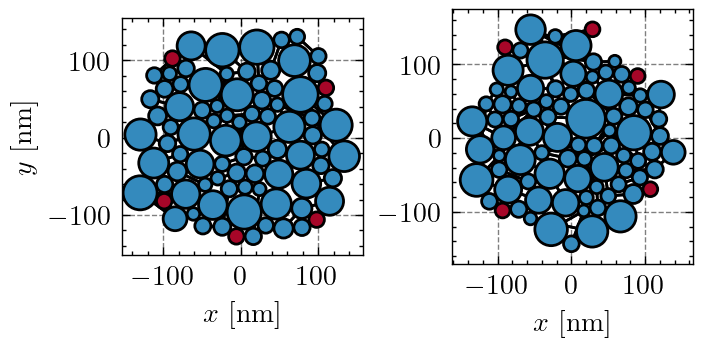

In [ ]:
G_lat           = lattice_net.get_graph()
pos_lat         = lattice_net.get_positions()
rad_lat         = lattice_net.get_radius()
net_topo_lat    = lattice_net.get_net_topology()
pos_lat         = force_directed_packing(pos_lat, rad_lat, k_attract=0.1, convergence_threshold=1e-3, step_size=0.02)

G_rng           = random_net.get_graph()
pos_rng         = random_net.get_positions()
rad_rng         = random_net.get_radius()
net_topo_rng    = random_net.get_net_topology()
pos_rng         = force_directed_packing(pos_rng, rad_rng, k_attract=0.1, convergence_threshold=1e-3, step_size=0.02)

fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot(1,2,1)
fig,ax  = display_network(G_lat, pos_lat, rad_lat, net_topo_lat, fig=fig, ax=ax)
_       = ax.set_xlabel("$x$ [nm]")
_       = ax.set_ylabel("$y$ [nm]")
ax      = fig.add_subplot(1,2,2)
fig,ax  = display_network(G_rng, pos_rng, rad_rng, net_topo_rng, fig=fig, ax=ax)
_       = ax.set_xlabel("$x$ [nm]")

In [16]:
# Lattice
N_x, N_y        = 9,9
electrode_pos   = [[(N_x-1)//2,0],[(N_x-1)//2,N_y-1]]
# electrode_pos   = [[(N_x-1)//2,0],[0,0],[N_x-1,0],
#                    [0,(N_y-1)//2],[N_x-1,(N_y-1)//2],
#                    [0,N_y-1],[N_x-1,N_y-1],[(N_x-1)//2,N_y-1]]
lattice_net = NanoparticleElectrostatic(['constant', 'constant'])

# Two NP Types
r_mean_2 = 5e0

# Build Network and attach Electrodes
lattice_net.lattice_network(N_x, N_y)
lattice_net.add_electrodes_to_lattice_net(electrode_pos)
lattice_net.add_np_to_output()
lattice_net.init_nanoparticle_radius()
lattice_net.update_nanoparticle_radius([N_x*N_y], mean_radius=r_mean_2)
lattice_net.pack_for_cubic()
lattice_net.calc_capacitance_matrix()
# lattice_net.pack_planar_circles()

In [17]:
G_lat           = lattice_net.get_graph()
pos_lat         = lattice_net.get_positions()
rad_lat         = lattice_net.get_radius()
dist_lat        = lattice_net.get_dist_matrix()
e_dist_lat      = lattice_net.get_electrode_dist_matrix()
net_topo_lat    = lattice_net.get_net_topology()
N_particles     = lattice_net.N_particles

(-100.0, 400.0)

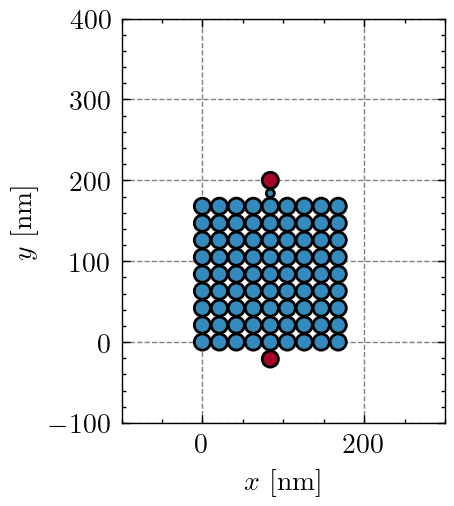

In [18]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
fig,ax  = display_network(G_lat, pos_lat, rad_lat, net_topo_lat, fig=fig, ax=ax)
_       = ax.set_xlabel("$x$ [nm]")
_       = ax.set_ylabel("$y$ [nm]")
ax.set_xlim(-100,300)
ax.set_ylim(-100,400)